In [1]:
CUDA_INDEX = 5
NAME = 'Protein'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [5]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [4]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

In [6]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

90.61
88.11
82.55
75.09
76.52


In [6]:
from scipy.stats import kendalltau
sed = (lb+ub)/2
for i, (label, pred) in enumerate(preds):
    tmp = []
    for i in range(len(queries)):
        tmp.append(kendalltau(sed[i], pred[i], nan_policy='omit')[0])
    tau = sum(tmp)/len(tmp)
    print(f'{tau:.3f}')

0.754
0.701
0.715
0.631
0.517
0.499


In [8]:
for label, pred in preds:
    Y = metrics.auroc_at_range(torch.tensor([1]), lb, ub, pred)
    Z = utils.nanmean(Y, dim=-1)
    print(f'{Z.item()*100:.2f}')

90.61
88.11
82.55
75.09
76.52


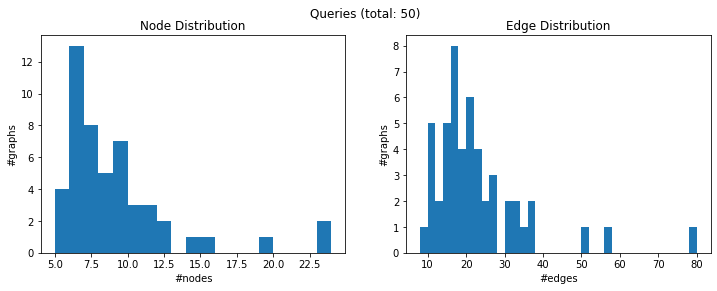

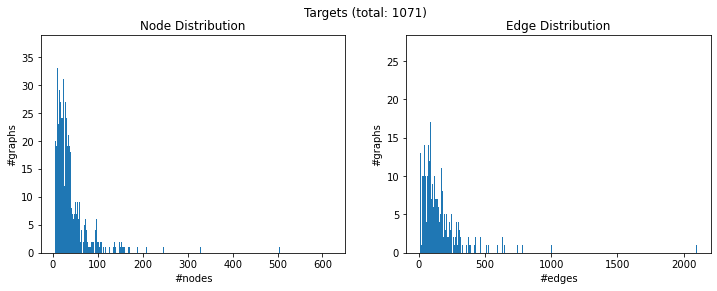

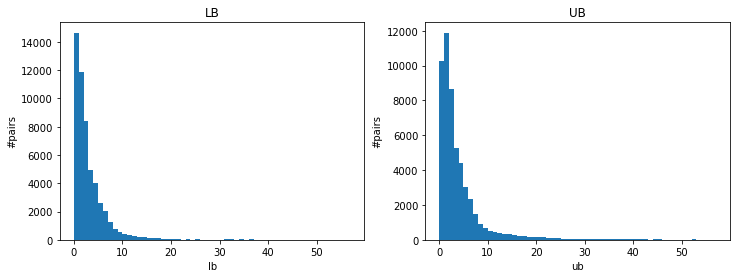

In [9]:
viz.plot_dataset_dist(outer_test_set)

In [7]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

In [10]:
print('=== Exact Precision @ k (k = 1 / 5 / 10 / 15 / 20) ===')
seds, idxs = torch.load(f'../data/{NAME}/topk_seds.pt')
for label, pred in preds:
    Y = metrics.exact_precision_at_k([1,5,10,15,20], seds, idxs, pred)
    Z = torch.mean(Y, dim=-1)
    for i in range(5):
        print(f'{Z[i].item()*100:.2f}', end=' / ' if i != 4 else '\n')

=== Exact Precision @ k (k = 1 / 5 / 10 / 15 / 20) ===


FileNotFoundError: [Errno 2] No such file or directory: '../data/Protein/topk_seds.pt'

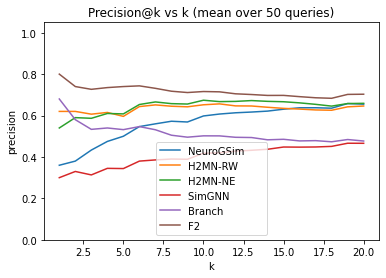

36.00 / 50.00 / 59.80 / 63.07 / 65.50
62.00 / 59.60 / 65.20 / 63.47 / 64.60
54.00 / 60.80 / 67.40 / 66.67 / 65.90
30.00 / 34.40 / 41.80 / 44.80 / 46.60
68.00 / 53.20 / 50.20 / 48.53 / 47.70
80.00 / 74.00 / 71.60 / 69.73 / 70.30


In [8]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [13]:
for label, pred in preds:
#     print(f'{label}', end='\t')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([20]), lb[:5], ub[:5], pred[:5])).item()
    print(f'{tmp*100:.2f}')
#     print()

91.58
94.32
91.79
87.16
82.74
69.47
66.32


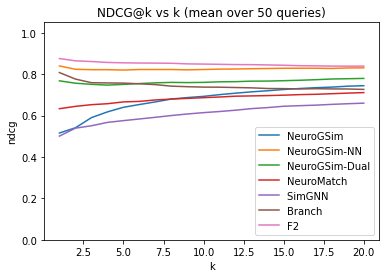

51.57 / 64.00 / 69.27 / 72.58 / 74.41
83.96 / 81.98 / 82.23 / 82.83 / 83.05
76.77 / 75.05 / 76.02 / 76.83 / 77.93
63.31 / 66.59 / 68.64 / 69.84 / 71.08
50.08 / 57.55 / 61.41 / 64.49 / 65.98
80.75 / 75.66 / 73.73 / 73.00 / 72.63
87.53 / 85.47 / 84.86 / 84.30 / 83.90


In [14]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG@k vs k (mean over {len(queries)} queries)')

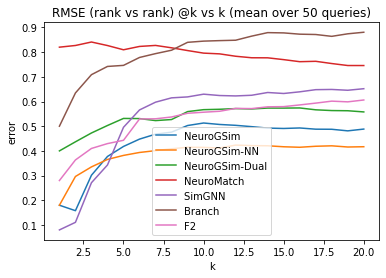

0.180 / 0.418 / 0.513 / 0.491 / 0.488
0.180 / 0.382 / 0.414 / 0.417 / 0.417
0.400 / 0.531 / 0.567 / 0.573 / 0.558
0.820 / 0.809 / 0.796 / 0.770 / 0.746
0.080 / 0.496 / 0.630 / 0.632 / 0.652
0.500 / 0.746 / 0.844 / 0.878 / 0.880
0.280 / 0.443 / 0.557 / 0.579 / 0.606


In [15]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

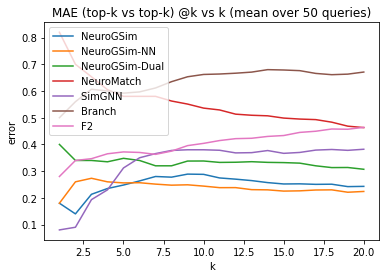

0.180 / 0.248 / 0.288 / 0.252 / 0.243
0.180 / 0.256 / 0.244 / 0.225 / 0.224
0.400 / 0.348 / 0.338 / 0.332 / 0.307
0.820 / 0.580 / 0.536 / 0.499 / 0.463
0.080 / 0.312 / 0.380 / 0.367 / 0.382
0.500 / 0.592 / 0.662 / 0.679 / 0.671
0.280 / 0.372 / 0.404 / 0.433 / 0.464


In [16]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)